# Gradient Boosting Classifier Model
---
* The model in this notebook was strongly influenced by Natural Chan.  The following gradient boosted classifier will be used in an ordinal regression dataset.
* This notebook will perform the following tasks / calculations:
    - Upload all of the wine quality dataset from S3 buckets or RAW github pages
    - Split the 20% of the data into a validation (val) dataset
    - Perform a grid parameter search to find the best parameters for the Gradient Boosting classifier from sklearn ensemble methods
    - Calculate weighted accuracy, precission, F1 scores, and provide a classification report printed to a txt file
    - Calculate the quadratic, weighted Cohen-Kappa score.  This score will be used as a base evaluation for the models performance based on the Kaggle Competion performance evaluation
    - Generate confusion matrices and save as a png file
* After all models are trained, then best version will make predictions of the test data provided from the Kaggle Compition.  THis data will be saved as a csv and upladed to the Kaggle compition submission portal to be scored again the other compition entries

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
from sklearn.metrics import ConfusionMatrixDisplay, cohen_kappa_score

import time

from warnings import filterwarnings
filterwarnings('ignore')

In [10]:
# The 'ID' feature is already dropped from cleaning notebook

# Open all source files as a pd dataframe
# This dataset will be used to train the gradient boosted model
orig_train = pd.read_csv('https://project4-wine-quality-2023.s3.us-west-2.amazonaws.com/train.csv')

#This dataset will be used to evaluate again the Kaggle compitition entry submission
orig_test = pd.read_csv('https://project4-wine-quality-2023.s3.us-west-2.amazonaws.com/test.csv')

# Addition datasets to explore the GradBoost model on actual wine data
red_data = pd.read_csv('https://raw.githubusercontent.com/Nicholas-Simpson/Project-4/main/gradient_boost/cleaned_data/red_white_data_noID.csv')
white_data = pd.read_csv('https://raw.githubusercontent.com/Nicholas-Simpson/Project-4/main/gradient_boost/cleaned_data/white_data_noID.csv')
red_white_data = pd.read_csv('https://raw.githubusercontent.com/Nicholas-Simpson/Project-4/main/gradient_boost/cleaned_data/red_white_data_noID.csv')
trainable_data = pd.read_csv('https://raw.githubusercontent.com/Nicholas-Simpson/Project-4/main/gradient_boost/cleaned_data/trainable_data_noID.csv')

# Drop 'ID' columns
orig_test = orig_test.drop(columns='Id')
orig_train = orig_train.drop(columns='Id')

# Create a place to save any generated files
gb_txt_output_path = os.path.join('../grad boost output','classification reports')
gb_png_output_path = os.path.join('../grad boost output','confusion plots')
os.makedirs(gb_txt_output_path, exist_ok = True)
os.makedirs( gb_png_output_path, exist_ok = True)

In [11]:
# Split the data into training and testing sets
X_train = orig_train.drop('quality', axis=1)
y_train = orig_train['quality'].copy()
X_test = orig_test.copy()
X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                  y_train, 
                                                  test_size = 0.2, 
                                                  random_state = 42) #because it is the answer :)

# Investigate Gradient Boosted Model Parameters

In [59]:
# Create a Gradient Boosting Regressor
model = GradientBoostingClassifier()

# Define the hyperparameter grid to search
param_grid = {
    'n_estimators': [50, 100, 200], # number of weak learning trees
    'learning_rate': [0.01, 0.1, 0.2], # control possibility of overfitting.
    # Strong interaction with n_estimators: smaller learning rates require more n_estimators
    'max_depth': [3, 5, 7] #  size of each tree
}

# Perform grid search with cross-validation, mark timer start
start_time = time.time()
grid_search = GridSearchCV(model, param_grid, cv=5, verbose=3)
grid_search.fit(X_train, y_train)

# Get the best model from grid search
best_gb = grid_search.best_estimator_
grid_search_time = time.time()

# Make predictions on the test data using the best model
y_pred = best_gb.predict(X_val)

# Report how long it took to complete Grid search and prediction
end_time = time.time()
grid_time = grid_search_time - start_time
pred_time = end_time - grid_search_time
tot_time = end_time - start_time

print(f"Time to complete Grid Search: {grid_time:.6f} seconds")
print(f"Time to complete prediction: {pred_time:.6f} seconds")
print(f"Total time to complete Grid Search and prediction: {tot_time:.6f} seconds")


Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV 1/5] END learning_rate=0.01, max_depth=3, n_estimators=50;, score=0.556 total time=   0.9s
[CV 2/5] END learning_rate=0.01, max_depth=3, n_estimators=50;, score=0.578 total time=   0.9s
[CV 3/5] END learning_rate=0.01, max_depth=3, n_estimators=50;, score=0.596 total time=   0.8s
[CV 4/5] END learning_rate=0.01, max_depth=3, n_estimators=50;, score=0.565 total time=   0.8s
[CV 5/5] END learning_rate=0.01, max_depth=3, n_estimators=50;, score=0.588 total time=   0.8s
[CV 1/5] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=0.568 total time=   1.8s
[CV 2/5] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=0.587 total time=   1.8s
[CV 3/5] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=0.611 total time=   1.7s
[CV 4/5] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=0.574 total time=   1.7s
[CV 5/5] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=0.591 to

In [60]:
# Create a Gradient Boosting Classifier with the best hyperparameters
best_params = {
    'n_estimators': best_gb.n_estimators,
    'learning_rate': best_gb.learning_rate,
    'max_depth': best_gb.max_depth
}
retrained_model = GradientBoostingClassifier(**best_params) # the ** tells python to unpack the dictionary

# Retrain the model on the entire training dataset
start_retrain = time.time()
retrained_model.fit(X_train, y_train)

# Make predictions on the validation set (or test set if needed) using the retrained model
y_pred_retrained = retrained_model.predict(X_val)
end_retrain = time.time()

# Calculate metrics
accuracy = accuracy_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred, average= 'weighted') # weighted average because the classification is not binary
precision = precision_score(y_val, y_pred, average= 'weighted')
recall = recall_score(y_val, y_pred, average= 'weighted')
kappa = cohen_kappa_score(y_val, y_pred, weights='quadratic')

# Determine how long it took to run model
retrain_time = end_retrain - start_retrain

print(f"Time to complete retrain model: {retrain_time:.4f}")

Time to complete retrain model: 3.7027


In [64]:
print("First Search Resuults:")
print("------------------------------------")
txt_file_name = f"{gb_txt_output_path}/gbc kappa: {kappa:.4f}   est: {best_gb.n_estimators}   LR: {best_gb.learning_rate}   depth: {best_gb.max_depth}  run_time: {retrain_time:.2f}.txt"
with open(txt_file_name, 'w') as txt_file:
    results=(
        f"Grid Search Parameters:\n"
        f"----------------------------------------------------------\n"
        f"Estimators used in grid search: {param_grid['n_estimators']}\n"
        f"Learning rates used in grid search: {param_grid['learning_rate']}\n"
        f"Tree node max depth in grid search: {param_grid['n_estimators']}\n"
        f"----------------------------------------------------------\n\n"
        
        f"Best Parameters Found:\n"
        f"----------------------------------------------------------\n"
        f"Best Estimators: {best_gb.n_estimators}\n"
        f"Best Learning Rate: {best_gb.learning_rate}\n"
        f"Best Max Depth: {best_gb.max_depth}\n"
        "----------------------------------------------------------\n\n"
        
        f"Model Performance:\n"
        f"----------------------------------------------------------\n"
        f"Accuracy: {accuracy:.2f}\n"
        f"F1: {f1:.2f}\n"
        f"Precision: {precision:.2f}\n"
        f"Recall: {recall:.2f}\n"
        f"Cohen Kappa Score, quadratic weighted: {kappa:.4f}\n"
        f"----------------------------------------------------------\n\n"

        f"Search and Training Duration\n"
        f"----------------------------------------------------------\n"
        f"Time to complete grid search: {grid_time:.6f} seconds\n"
        f"Time to run model with best params: {retrain_time:.6f} seconds\n"
        f"----------------------------------------------------------\n\n"
        f"***End Report***"
    )
    print(results)

    #save to txt file
    txt_file.write(results)


First Search Resuults:
------------------------------------
Grid Search Parameters:
----------------------------------------------------------
Estimators used in grid search: [50, 100, 200]
Learning rates used in grid search: [0.01, 0.1, 0.2]
Tree node max depth in grid search: [50, 100, 200]
----------------------------------------------------------

Best Parameters Found:
----------------------------------------------------------
Best Estimators: 200
Best Learning Rate: 0.01
Best Max Depth: 3
----------------------------------------------------------

Model Performance:
----------------------------------------------------------
Accuracy: 0.59
F1: 0.57
Precision: 0.59
Recall: 0.59
Cohen Kappa Score, quadratic weighted: 0.4648
----------------------------------------------------------

Search and Training Duration
----------------------------------------------------------
Time to complete grid search: 445.469036 seconds
Time to run model with best params: 3.702673 seconds
-------------

In [56]:
# Change the number of weak learner trees
# Create a Gradient Boosting Regressor
model_2 = GradientBoostingClassifier()

# Define the hyperparameter grid to search
param_grid_2 = {
    'n_estimators': [200, 400, 800],
    'learning_rate': [0.001, 0.01, 0.1],
    'max_depth': [3, 5, 7]
}

# Perform grid search with cross-validation
start_time_2 = time.time()
grid_search_2 = GridSearchCV(model_2, param_grid_2, cv=5, verbose=3)
grid_search_2.fit(X_train, y_train)

# Get the best model from grid search
best_gb_2 = grid_search_2.best_estimator_
grid_search_time_2 = time.time()

# Make predictions on the test data using the best model
y_pred_2 = best_gb_2.predict(X_val)

# Report how long it took to complete Grid search and prediction
end_time_2 = time.time()
grid_time_2 = grid_search_time_2 - start_time_2
pred_time_2 = end_time_2 - grid_search_time_2
tot_time_2 = end_time_2 - start_time_2

print(f"Time to complete Grid Search: {grid_time_2:.6f} seconds")
print(f"Time to complete prediction: {pred_time_2:.6f} seconds")
print(f"Total time to complete Grid Search and prediction: {tot_time_2:.6f} seconds")

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV 1/5] END learning_rate=0.001, max_depth=3, n_estimators=200;, score=0.574 total time=   3.4s
[CV 2/5] END learning_rate=0.001, max_depth=3, n_estimators=200;, score=0.578 total time=   3.3s
[CV 3/5] END learning_rate=0.001, max_depth=3, n_estimators=200;, score=0.581 total time=   3.3s
[CV 4/5] END learning_rate=0.001, max_depth=3, n_estimators=200;, score=0.562 total time=   3.4s
[CV 5/5] END learning_rate=0.001, max_depth=3, n_estimators=200;, score=0.582 total time=   3.2s
[CV 1/5] END learning_rate=0.001, max_depth=3, n_estimators=400;, score=0.565 total time=   6.5s
[CV 2/5] END learning_rate=0.001, max_depth=3, n_estimators=400;, score=0.562 total time=   6.7s
[CV 3/5] END learning_rate=0.001, max_depth=3, n_estimators=400;, score=0.593 total time=   6.5s
[CV 4/5] END learning_rate=0.001, max_depth=3, n_estimators=400;, score=0.571 total time=   6.5s
[CV 5/5] END learning_rate=0.001, max_depth=3, n_estimators=400;,

In [57]:
# Create a Gradient Boosting Classifier with the best hyperparameters to retrain the model to calculate computation timing
best_params_2 = {
    'n_estimators': best_gb_2.n_estimators,
    'learning_rate': best_gb_2.learning_rate,
    'max_depth': best_gb_2.max_depth
}
retrained_model_2 = GradientBoostingClassifier(**best_params_2) # the ** tells python to unpack the dictionary

# Retrain the model on the entire training dataset
start_retrain_2 = time.time()
retrained_model_2.fit(X_train, y_train)

# Make predictions on the validation set (or test set if needed) using the retrained model
y_pred_retrained_2 = retrained_model_2.predict(X_val)
end_retrain_2 = time.time()

# Calculate metrics
accuracy_2 = accuracy_score(y_val, y_pred_2)
# the following metrics need to include the average type since the validation is ordinal and not binary
f1_2 = f1_score(y_val, y_pred_2, average= 'weighted')
precision_2 = precision_score(y_val, y_pred_2, average= 'weighted')
recall_2 = recall_score(y_val, y_pred_2, average= 'weighted')
kappa_2 = cohen_kappa_score(y_val, y_pred_2, weights='quadratic')

# Determine how long it took to run model
retrain_time_2 = end_retrain_2 - start_retrain_2

print(f"Time to complete retrain model: {retrain_time_2:.4f}")

Time to complete retrain model: 7.5999


In [66]:
print("Second Search Resuults:")
print("------------------------------------")
txt_file_name = f"{gb_txt_output_path}/gbc kappa: {kappa_2:.4f}   est: {best_gb_2.n_estimators}   LR: {best_gb_2.learning_rate}   depth: {best_gb_2.max_depth}  run_time: {retrain_time_2:.2f}.txt"
with open(txt_file_name, 'w') as txt_file:
    results=(
        f"Grid Search Parameters:\n"
        f"----------------------------------------------------------\n"
        f"Estimators used in grid search: {param_grid_2['n_estimators']}\n"
        f"Learning rates used in grid search: {param_grid_2['learning_rate']}\n"
        f"Tree node max depth in grid search: {param_grid_2['n_estimators']}\n"
        f"----------------------------------------------------------\n\n"
        
        f"Best Parameters Found:\n"
        f"----------------------------------------------------------\n"
        f"Best Estimators: {best_gb_2.n_estimators}\n"
        f"Best Learning Rate: {best_gb_2.learning_rate}\n"
        f"Best Max Depth: {best_gb_2.max_depth}\n"
        "----------------------------------------------------------\n\n"
        
        f"Model Performance:\n"
        f"----------------------------------------------------------\n"
        f"Accuracy: {accuracy_2:.2f}\n"
        f"F1: {f1_2:.2f}\n"
        f"Precision: {precision_2:.2f}\n"
        f"Recall: {recall_2:.2f}\n"
        f"Cohen Kappa Score, quadratic weighted: {kappa_2:.4f}\n"
        f"----------------------------------------------------------\n\n"

        f"Search and Training Duration\n"
        f"----------------------------------------------------------\n"
        f"Time to complete grid search: {grid_time_2:.6f} seconds\n"
        f"Time to run model with best params: {retrain_time_2:.6f} seconds\n"
        f"----------------------------------------------------------\n\n"
        f"***End Report***"
    )
    print(results)

    #save to txt file
    txt_file.write(results)

Second Search Resuults:
------------------------------------
Grid Search Parameters:
----------------------------------------------------------
Estimators used in grid search: [200, 400, 800]
Learning rates used in grid search: [0.001, 0.01, 0.1]
Tree node max depth in grid search: [200, 400, 800]
----------------------------------------------------------

Best Parameters Found:
----------------------------------------------------------
Best Estimators: 400
Best Learning Rate: 0.01
Best Max Depth: 3
----------------------------------------------------------

Model Performance:
----------------------------------------------------------
Accuracy: 0.59
F1: 0.57
Precision: 0.58
Recall: 0.59
Cohen Kappa Score, quadratic weighted: 0.4534
----------------------------------------------------------

Search and Training Duration
----------------------------------------------------------
Time to complete grid search: 1718.416880 seconds
Time to run model with best params: 7.599855 seconds
-------

In [67]:
# Change the number of weak learner trees
# Create a Gradient Boosting Regressor
model_3 = GradientBoostingClassifier()

# Define the hyperparameter grid to search
param_grid_3 = {
    'n_estimators': [200, 400, 800],
    'learning_rate': [0.001, 0.01, 0.1],
    'max_depth': [2, 3, 5]
}

# Perform grid search with cross-validation
start_time_3 = time.time()
grid_search_3 = GridSearchCV(model_3, param_grid_3, cv=5, verbose=3)
grid_search_3.fit(X_train, y_train)

# Get the best model from grid search
best_gb_3 = grid_search_3.best_estimator_
grid_search_time_3 = time.time()

# Make predictions on the test data using the best model
y_pred_3 = best_gb_3.predict(X_val)

# Report how long it took to complete Grid search and prediction
end_time_3 = time.time()
grid_time_3 = grid_search_time_3 - start_time_3
pred_time_3 = end_time_3 - grid_search_time_3
tot_time_3 = end_time_3 - start_time_3

print(f"Time to complete Grid Search: {grid_time_3:.6f} seconds")
print(f"Time to complete prediction: {pred_time_3:.6f} seconds")
print(f"Total time to complete Grid Search and prediction: {tot_time_3:.6f} seconds")

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV 1/5] END learning_rate=0.001, max_depth=2, n_estimators=200;, score=0.556 total time=   2.5s
[CV 2/5] END learning_rate=0.001, max_depth=2, n_estimators=200;, score=0.584 total time=   2.4s
[CV 3/5] END learning_rate=0.001, max_depth=2, n_estimators=200;, score=0.578 total time=   2.5s
[CV 4/5] END learning_rate=0.001, max_depth=2, n_estimators=200;, score=0.517 total time=   2.5s
[CV 5/5] END learning_rate=0.001, max_depth=2, n_estimators=200;, score=0.570 total time=   2.5s
[CV 1/5] END learning_rate=0.001, max_depth=2, n_estimators=400;, score=0.544 total time=   5.0s
[CV 2/5] END learning_rate=0.001, max_depth=2, n_estimators=400;, score=0.584 total time=   5.0s
[CV 3/5] END learning_rate=0.001, max_depth=2, n_estimators=400;, score=0.587 total time=   5.8s
[CV 4/5] END learning_rate=0.001, max_depth=2, n_estimators=400;, score=0.550 total time=   5.1s
[CV 5/5] END learning_rate=0.001, max_depth=2, n_estimators=400;,

In [68]:
# Create a Gradient Boosting Classifier with the best hyperparameters to retrain the model to calculate computation timing
best_params_3 = {
    'n_estimators': best_gb_3.n_estimators,
    'learning_rate': best_gb_3.learning_rate,
    'max_depth': best_gb_3.max_depth
}
retrained_model_3 = GradientBoostingClassifier(**best_params_3) # the ** tells python to unpack the dictionary

# Retrain the model on the entire training dataset
start_retrain_3 = time.time()
retrained_model_3.fit(X_train, y_train)

# Make predictions on the validation set (or test set if needed) using the retrained model
y_pred_retrained_3 = retrained_model_3.predict(X_val)
end_retrain_3 = time.time()

# Calculate metrics
accuracy_3 = accuracy_score(y_val, y_pred_3)
# the following metrics need to include the average type since the validation is ordinal and not binary
f1_3 = f1_score(y_val, y_pred_3, average= 'weighted')
precision_3 = precision_score(y_val, y_pred_3, average= 'weighted')
recall_3 = recall_score(y_val, y_pred_3, average= 'weighted')
kappa_3 = cohen_kappa_score(y_val, y_pred_3, weights='quadratic')

# Determine how long it took to run model
retrain_time_3 = end_retrain_3 - start_retrain_3

print(f"Time to complete retrain model: {retrain_time_3:.4f}")

Time to complete retrain model: 6.5510


In [69]:
print("Third Search Results:")
print("------------------------------------")
txt_file_name = f"{gb_txt_output_path}/gbc kappa: {kappa_3:.4f}   est: {best_gb_3.n_estimators}   LR: {best_gb_3.learning_rate}   depth: {best_gb_3.max_depth}  run_time: {retrain_time_3:.2f}.txt"
with open(txt_file_name, 'w') as txt_file:
    results=(
        f"Grid Search Parameters:\n"
        f"----------------------------------------------------------\n"
        f"Estimators used in grid search: {param_grid_3['n_estimators']}\n"
        f"Learning rates used in grid search: {param_grid_3['learning_rate']}\n"
        f"Tree node max depth in grid search: {param_grid_3['n_estimators']}\n"
        f"----------------------------------------------------------\n\n"
        
        f"Best Parameters Found:\n"
        f"----------------------------------------------------------\n"
        f"Best Estimators: {best_gb_3.n_estimators}\n"
        f"Best Learning Rate: {best_gb_3.learning_rate}\n"
        f"Best Max Depth: {best_gb_3.max_depth}\n"
        "----------------------------------------------------------\n\n"
        
        f"Model Performance:\n"
        f"----------------------------------------------------------\n"
        f"Accuracy: {accuracy_3:.2f}\n"
        f"F1: {f1_3:.2f}\n"
        f"Precision: {precision_3:.2f}\n"
        f"Recall: {recall_3:.2f}\n"
        f"Cohen Kappa Score, quadratic weighted: {kappa_3:.4f}\n"
        f"----------------------------------------------------------\n\n"

        f"Search and Training Duration\n"
        f"----------------------------------------------------------\n"
        f"Time to complete grid search: {grid_time_3:.6f} seconds\n"
        f"Time to run model with best params: {retrain_time_3:.6f} seconds\n"
        f"----------------------------------------------------------\n\n"
        f"***End Report***"
    )
    print(results)

    #save to txt file
    txt_file.write(results)

Third Search Results:
------------------------------------
Grid Search Parameters:
----------------------------------------------------------
Estimators used in grid search: [200, 400, 800]
Learning rates used in grid search: [0.001, 0.01, 0.1]
Tree node max depth in grid search: [200, 400, 800]
----------------------------------------------------------

Best Parameters Found:
----------------------------------------------------------
Best Estimators: 400
Best Learning Rate: 0.01
Best Max Depth: 2
----------------------------------------------------------

Model Performance:
----------------------------------------------------------
Accuracy: 0.61
F1: 0.59
Precision: 0.60
Recall: 0.61
Cohen Kappa Score, quadratic weighted: 0.4962
----------------------------------------------------------

Search and Training Duration
----------------------------------------------------------
Time to complete grid search: 1158.770948 seconds
Time to run model with best params: 6.550963 seconds
---------

In [70]:
# Change the number of weak learner trees
# Create a Gradient Boosting Regressor
model_4 = GradientBoostingClassifier()

# Define the hyperparameter grid to search
param_grid_4 = {
    'n_estimators': [10, 20, 30, 40, 50, 75, 100, 150],
    'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.2],
    'max_depth': [2, 3, 5, 7, 9]
}

# Perform grid search with cross-validation
start_time_4 = time.time()
grid_search_4 = GridSearchCV(model_4, param_grid_4, cv=5, verbose=3)
grid_search_4.fit(X_train, y_train)

# Get the best model from grid search
best_gb_4 = grid_search_4.best_estimator_
grid_search_time_4 = time.time()

# Make predictions on the test data using the best model
y_pred_4 = best_gb_4.predict(X_val)

# Report how long it took to complete Grid search and prediction
end_time_4 = time.time()
grid_time_4 = grid_search_time_4 - start_time_4
pred_time_4 = end_time_4 - grid_search_time_4
tot_time_4 = end_time_4 - start_time_4

print(f"Time to complete Grid Search: {grid_time_4:.6f} seconds")
print(f"Time to complete prediction: {pred_time_4:.6f} seconds")
print(f"Total time to complete Grid Search and prediction: {tot_time_4:.6f} seconds")

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
[CV 1/5] END learning_rate=0.001, max_depth=2, n_estimators=10;, score=0.407 total time=   0.1s
[CV 2/5] END learning_rate=0.001, max_depth=2, n_estimators=10;, score=0.407 total time=   0.1s
[CV 3/5] END learning_rate=0.001, max_depth=2, n_estimators=10;, score=0.407 total time=   0.1s
[CV 4/5] END learning_rate=0.001, max_depth=2, n_estimators=10;, score=0.407 total time=   0.1s
[CV 5/5] END learning_rate=0.001, max_depth=2, n_estimators=10;, score=0.409 total time=   0.1s
[CV 1/5] END learning_rate=0.001, max_depth=2, n_estimators=20;, score=0.407 total time=   0.3s
[CV 2/5] END learning_rate=0.001, max_depth=2, n_estimators=20;, score=0.407 total time=   0.3s
[CV 3/5] END learning_rate=0.001, max_depth=2, n_estimators=20;, score=0.407 total time=   0.3s
[CV 4/5] END learning_rate=0.001, max_depth=2, n_estimators=20;, score=0.407 total time=   0.3s
[CV 5/5] END learning_rate=0.001, max_depth=2, n_estimators=20;, score=0

In [71]:
# Create a Gradient Boosting Classifier with the best hyperparameters to retrain the model to calculate computation timing
best_params_4 = {
    'n_estimators': best_gb_4.n_estimators,
    'learning_rate': best_gb_4.learning_rate,
    'max_depth': best_gb_4.max_depth
}
retrained_model_4 = GradientBoostingClassifier(**best_params_4) # the ** tells python to unpack the dictionary

# Retrain the model on the entire training dataset
start_retrain_4 = time.time()
retrained_model_4.fit(X_train, y_train)

# Make predictions on the validation set (or test set if needed) using the retrained model
y_pred_retrained_4 = retrained_model_4.predict(X_val)
end_retrain_4 = time.time()

# Calculate metrics
accuracy_4 = accuracy_score(y_val, y_pred_4)
# the following metrics need to include the average type since the validation is ordinal and not binary
f1_4 = f1_score(y_val, y_pred_4, average= 'weighted')
precision_4 = precision_score(y_val, y_pred_4, average= 'weighted')
recall_4 = recall_score(y_val, y_pred_4, average= 'weighted')
kappa_4 = cohen_kappa_score(y_val, y_pred_4, weights='quadratic')

# Determine how long it took to run model
retrain_time_4 = end_retrain_4 - start_retrain_4

print(f"Time to complete retrain model: {retrain_time_4:.4f}")

Time to complete retrain model: 0.4269


In [72]:
print("Fourth Search Results:")
print("------------------------------------")
txt_file_name = f"{gb_txt_output_path}/gbc kappa: {kappa_4:.4f}   est: {best_gb_4.n_estimators}   LR: {best_gb_4.learning_rate}   depth: {best_gb_4.max_depth}  run_time: {retrain_time_4:.2f}.txt"
with open(txt_file_name, 'w') as txt_file:
    results=(
        f"Grid Search Parameters:\n"
        f"----------------------------------------------------------\n"
        f"Estimators used in grid search: {param_grid_4['n_estimators']}\n"
        f"Learning rates used in grid search: {param_grid_4['learning_rate']}\n"
        f"Tree node max depth in grid search: {param_grid_4['n_estimators']}\n"
        f"----------------------------------------------------------\n\n"
        
        f"Best Parameters Found:\n"
        f"----------------------------------------------------------\n"
        f"Best Estimators: {best_gb_4.n_estimators}\n"
        f"Best Learning Rate: {best_gb_4.learning_rate}\n"
        f"Best Max Depth: {best_gb_4.max_depth}\n"
        "----------------------------------------------------------\n\n"
        
        f"Model Performance:\n"
        f"----------------------------------------------------------\n"
        f"Accuracy: {accuracy_4:.2f}\n"
        f"F1: {f1_4:.2f}\n"
        f"Precision: {precision_4:.2f}\n"
        f"Recall: {recall_4:.2f}\n"
        f"Cohen Kappa Score, quadratic weighted: {kappa_4:.4f}\n"
        f"----------------------------------------------------------\n\n"

        f"Search and Training Duration\n"
        f"----------------------------------------------------------\n"
        f"Time to complete grid search: {grid_time_4:.6f} seconds\n"
        f"Time to run model with best params: {retrain_time_4:.6f} seconds\n"
        f"----------------------------------------------------------\n\n"
        f"***End Report***"
    )
    print(results)

    #save to txt file
    txt_file.write(results)

Fourth Search Results:
------------------------------------
Grid Search Parameters:
----------------------------------------------------------
Estimators used in grid search: [10, 20, 30, 40, 50, 75, 100, 150]
Learning rates used in grid search: [0.001, 0.01, 0.05, 0.1, 0.2]
Tree node max depth in grid search: [10, 20, 30, 40, 50, 75, 100, 150]
----------------------------------------------------------

Best Parameters Found:
----------------------------------------------------------
Best Estimators: 30
Best Learning Rate: 0.1
Best Max Depth: 2
----------------------------------------------------------

Model Performance:
----------------------------------------------------------
Accuracy: 0.61
F1: 0.59
Precision: 0.61
Recall: 0.61
Cohen Kappa Score, quadratic weighted: 0.4933
----------------------------------------------------------

Search and Training Duration
----------------------------------------------------------
Time to complete grid search: 1965.019034 seconds
Time to run mo

# Classification Reports

In [73]:
CR_1 = classification_report(y_val,y_pred)

print("First Search Results:")
print("------------------------------------")
txt_file_name = f"{gb_txt_output_path}/gbc kappa: {kappa:.4f}   est: {best_gb.n_estimators}   LR: {best_gb.learning_rate}   depth: {best_gb.max_depth}  run_time: {retrain_time:.2f}.txt"
with open(txt_file_name, 'w') as txt_file:
    results=(
        f"Grid Search Parameters:\n"
        f"----------------------------------------------------------\n"
        f"Estimators used in grid search: {param_grid['n_estimators']}\n"
        f"Learning rates used in grid search: {param_grid['learning_rate']}\n"
        f"Tree node max depth in grid search: {param_grid['n_estimators']}\n"
        f"----------------------------------------------------------\n\n"
        
        f"Best Parameters Found:\n"
        f"----------------------------------------------------------\n"
        f"Best Estimators: {best_gb.n_estimators}\n"
        f"Best Learning Rate: {best_gb.learning_rate}\n"
        f"Best Max Depth: {best_gb.max_depth}\n"
        "----------------------------------------------------------\n\n"
        
        f"Classification Report\n"  
        f"-----------------------------------------------------------------------\n"
        f"{CR_1}\n"
        f"-----------------------------------------------------------------------\n\n"
        
        f"Model Performance:\n"
        f"----------------------------------------------------------\n"
        f"Accuracy: {accuracy:.2f}\n"
        f"F1: {f1:.2f}\n"
        f"Precision: {precision:.2f}\n"
        f"Recall: {recall:.2f}\n"
        f"Cohen Kappa Score, quadratic weighted: {kappa:.4f}\n"
        f"----------------------------------------------------------\n\n"

        f"Search and Training Duration\n"
        f"----------------------------------------------------------\n"
        f"Time to complete grid search: {grid_time:.6f} seconds\n"
        f"Time to run model with best params: {retrain_time:.6f} seconds\n"
        f"----------------------------------------------------------\n\n"
        f"***End Report***"
    )
    print(results)

    #save to txt file
    txt_file.write(results)


First Search Results:
------------------------------------
Grid Search Parameters:
----------------------------------------------------------
Estimators used in grid search: [50, 100, 200]
Learning rates used in grid search: [0.01, 0.1, 0.2]
Tree node max depth in grid search: [50, 100, 200]
----------------------------------------------------------

Best Parameters Found:
----------------------------------------------------------
Best Estimators: 200
Best Learning Rate: 0.01
Best Max Depth: 3
----------------------------------------------------------

Classification Report
-----------------------------------------------------------------------
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       1.00      0.12      0.22         8
           5       0.65      0.74      0.69       169
           6       0.52      0.60      0.56       158
           7       0.61      0.32      0.42        69
           8       0.0

In [74]:
CR_2 = classification_report(y_val,y_pred_2)

print("Second Search Resuults:")
print("------------------------------------")
txt_file_name = f"{gb_txt_output_path}/gbc kappa: {kappa_2:.4f}   est: {best_gb_2.n_estimators}   LR: {best_gb_2.learning_rate}   depth: {best_gb_2.max_depth}  run_time: {retrain_time_2:.2f}.txt"
with open(txt_file_name, 'w') as txt_file:
    results=(
        f"Grid Search Parameters:\n"
        f"----------------------------------------------------------\n"
        f"Estimators used in grid search: {param_grid_2['n_estimators']}\n"
        f"Learning rates used in grid search: {param_grid_2['learning_rate']}\n"
        f"Tree node max depth in grid search: {param_grid_2['n_estimators']}\n"
        f"----------------------------------------------------------\n\n"
        
        f"Best Parameters Found:\n"
        f"----------------------------------------------------------\n"
        f"Best Estimators: {best_gb_2.n_estimators}\n"
        f"Best Learning Rate: {best_gb_2.learning_rate}\n"
        f"Best Max Depth: {best_gb_2.max_depth}\n"
        "----------------------------------------------------------\n\n"

        f"Classification Report\n"  
        f"-----------------------------------------------------------------------\n"
        f"{CR_2}\n"
        f"-----------------------------------------------------------------------\n\n"
        
        f"Model Performance:\n"
        f"----------------------------------------------------------\n"
        f"Accuracy: {accuracy_2:.2f}\n"
        f"F1: {f1_2:.2f}\n"
        f"Precision: {precision_2:.2f}\n"
        f"Recall: {recall_2:.2f}\n"
        f"Cohen Kappa Score, quadratic weighted: {kappa_2:.4f}\n"
        f"----------------------------------------------------------\n\n"

        f"Search and Training Duration\n"
        f"----------------------------------------------------------\n"
        f"Time to complete grid search: {grid_time_2:.6f} seconds\n"
        f"Time to run model with best params: {retrain_time_2:.6f} seconds\n"
        f"----------------------------------------------------------\n\n"
        f"***End Report***"
    )
    print(results)

    #save to txt file
    txt_file.write(results)

Second Search Resuults:
------------------------------------
Grid Search Parameters:
----------------------------------------------------------
Estimators used in grid search: [200, 400, 800]
Learning rates used in grid search: [0.001, 0.01, 0.1]
Tree node max depth in grid search: [200, 400, 800]
----------------------------------------------------------

Best Parameters Found:
----------------------------------------------------------
Best Estimators: 400
Best Learning Rate: 0.01
Best Max Depth: 3
----------------------------------------------------------

Classification Report
-----------------------------------------------------------------------
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       1.00      0.12      0.22         8
           5       0.65      0.73      0.69       169
           6       0.52      0.59      0.56       158
           7       0.57      0.35      0.43        69
           8    

In [75]:
CR_3 = classification_report(y_val,y_pred_3)

print("Third Search Results:")
print("------------------------------------")
txt_file_name = f"{gb_txt_output_path}/gbc kappa: {kappa_3:.4f}   est: {best_gb_3.n_estimators}   LR: {best_gb_3.learning_rate}   depth: {best_gb_3.max_depth}  run_time: {retrain_time_3:.2f}.txt"
with open(txt_file_name, 'w') as txt_file:
    results=(
        f"Grid Search Parameters:\n"
        f"----------------------------------------------------------\n"
        f"Estimators used in grid search: {param_grid_3['n_estimators']}\n"
        f"Learning rates used in grid search: {param_grid_3['learning_rate']}\n"
        f"Tree node max depth in grid search: {param_grid_3['n_estimators']}\n"
        f"----------------------------------------------------------\n\n"
        
        f"Best Parameters Found:\n"
        f"----------------------------------------------------------\n"
        f"Best Estimators: {best_gb_3.n_estimators}\n"
        f"Best Learning Rate: {best_gb_3.learning_rate}\n"
        f"Best Max Depth: {best_gb_3.max_depth}\n"
        "----------------------------------------------------------\n\n"

        f"Classification Report\n"  
        f"-----------------------------------------------------------------------\n"
        f"{CR_3}\n"
        f"-----------------------------------------------------------------------\n\n"
        
        f"Model Performance:\n"
        f"----------------------------------------------------------\n"
        f"Accuracy: {accuracy_3:.2f}\n"
        f"F1: {f1_3:.2f}\n"
        f"Precision: {precision_3:.2f}\n"
        f"Recall: {recall_3:.2f}\n"
        f"Cohen Kappa Score, quadratic weighted: {kappa_3:.4f}\n"
        f"----------------------------------------------------------\n\n"

        f"Search and Training Duration\n"
        f"----------------------------------------------------------\n"
        f"Time to complete grid search: {grid_time_3:.6f} seconds\n"
        f"Time to run model with best params: {retrain_time_3:.6f} seconds\n"
        f"----------------------------------------------------------\n\n"
        f"***End Report***"
    )
    print(results)

    #save to txt file
    txt_file.write(results)

Third Search Results:
------------------------------------
Grid Search Parameters:
----------------------------------------------------------
Estimators used in grid search: [200, 400, 800]
Learning rates used in grid search: [0.001, 0.01, 0.1]
Tree node max depth in grid search: [200, 400, 800]
----------------------------------------------------------

Best Parameters Found:
----------------------------------------------------------
Best Estimators: 400
Best Learning Rate: 0.01
Best Max Depth: 2
----------------------------------------------------------

Classification Report
-----------------------------------------------------------------------
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00         8
           5       0.67      0.73      0.70       169
           6       0.54      0.65      0.59       158
           7       0.70      0.38      0.49        69
           8      

In [76]:
CR_4 = classification_report(y_val,y_pred_4)

print("Fourth Search Results:")
print("------------------------------------")
txt_file_name = f"{gb_txt_output_path}/gbc kappa: {kappa_4:.4f}   est: {best_gb_4.n_estimators}   LR: {best_gb_4.learning_rate}   depth: {best_gb_4.max_depth}  run_time: {retrain_time_4:.2f}.txt"
with open(txt_file_name, 'w') as txt_file:
    results=(
        f"Grid Search Parameters:\n"
        f"----------------------------------------------------------\n"
        f"Estimators used in grid search: {param_grid_4['n_estimators']}\n"
        f"Learning rates used in grid search: {param_grid_4['learning_rate']}\n"
        f"Tree node max depth in grid search: {param_grid_4['n_estimators']}\n"
        f"----------------------------------------------------------\n\n"
        
        f"Best Parameters Found:\n"
        f"----------------------------------------------------------\n"
        f"Best Estimators: {best_gb_4.n_estimators}\n"
        f"Best Learning Rate: {best_gb_4.learning_rate}\n"
        f"Best Max Depth: {best_gb_4.max_depth}\n"
        "----------------------------------------------------------\n\n"

        f"Classification Report\n"  
        f"-----------------------------------------------------------------------\n"
        f"{CR_3}\n"
        f"-----------------------------------------------------------------------\n\n"
        
        
        f"Model Performance:\n"
        f"----------------------------------------------------------\n"
        f"Accuracy: {accuracy_4:.2f}\n"
        f"F1: {f1_4:.2f}\n"
        f"Precision: {precision_4:.2f}\n"
        f"Recall: {recall_4:.2f}\n"
        f"Cohen Kappa Score, quadratic weighted: {kappa_4:.4f}\n"
        f"----------------------------------------------------------\n\n"

        f"Search and Training Duration\n"
        f"----------------------------------------------------------\n"
        f"Time to complete grid search: {grid_time_4:.6f} seconds\n"
        f"Time to run model with best params: {retrain_time_4:.6f} seconds\n"
        f"----------------------------------------------------------\n\n"
        f"***End Report***"
    )
    print(results)

    #save to txt file
    txt_file.write(results)

Fourth Search Results:
------------------------------------
Grid Search Parameters:
----------------------------------------------------------
Estimators used in grid search: [10, 20, 30, 40, 50, 75, 100, 150]
Learning rates used in grid search: [0.001, 0.01, 0.05, 0.1, 0.2]
Tree node max depth in grid search: [10, 20, 30, 40, 50, 75, 100, 150]
----------------------------------------------------------

Best Parameters Found:
----------------------------------------------------------
Best Estimators: 30
Best Learning Rate: 0.1
Best Max Depth: 2
----------------------------------------------------------

Classification Report
-----------------------------------------------------------------------
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00         8
           5       0.67      0.73      0.70       169
           6       0.54      0.65      0.59       158
           7       0.70 

# Confusion Matrix

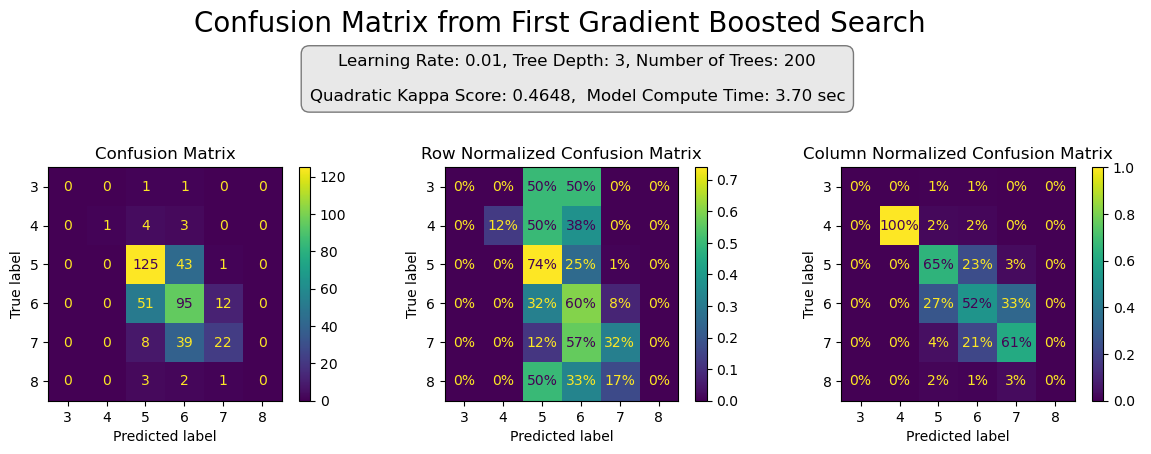

In [146]:
# Create the figure and gridspec
fig = plt.figure(figsize = (12,4.5))
grid_spec = GridSpec(3, 3, figure=fig, width_ratios = [1,1,1], height_ratios=[1,2,10])

# Model specs subplot
model_specs=  f"Learning Rate: {best_gb.learning_rate}, Tree Depth: {best_gb.max_depth}, Number of Trees: {best_gb.n_estimators}\n\nQuadratic Kappa Score: {kappa:.4f},  Model Compute Time: {retrain_time:.2f} sec"   
center_ax = fig.add_subplot(grid_spec[1, :])

# plt.center_ax_adjust(hspace = 0.5)
center_text = center_ax.text(0.5, 0.55, model_specs, ha='center', fontsize=12,
                           bbox=dict(facecolor='lightgray', alpha=0.5, boxstyle='round,pad=0.5'))
center_ax.axis('off')

# Confusion Matrix Subplot
conf_matrix_display = ConfusionMatrixDisplay.from_predictions(y_val, y_pred, ax=fig.add_subplot(grid_spec[2, 0]))
conf_matrix_display.ax_.set_title("Confusion Matrix")

# Row (True) Normalized Confusion Matrix Subplot
row_normalized_conf_matrix_display = ConfusionMatrixDisplay.from_predictions(y_val, y_pred,
                                                                         normalize='true',
                                                                         values_format='.0%',
                                                                         ax=fig.add_subplot(grid_spec[2, 1]))
row_normalized_conf_matrix_display.ax_.set_title("Row Normalized Confusion Matrix")

# Column (Predicted) Normalized Confusion Matrix Subplot
clm_normalized_conf_matrix_display = ConfusionMatrixDisplay.from_predictions(y_val, y_pred,
                                                                         normalize='pred',
                                                                         values_format='.0%',
                                                                         ax=fig.add_subplot(grid_spec[2, 2]))
clm_normalized_conf_matrix_display.ax_.set_title("Column Normalized Confusion Matrix")

# Adjust Layout
plt.tight_layout()
fig.suptitle("Confusion Matrix from First Gradient Boosted Search", fontsize=20)

# Save and show the figure
output_filename = f"{gb_png_output_path}/gb_cm kappa={kappa:.4f}  est: {best_gb.n_estimators}   LR: {best_gb.learning_rate}   depth: {best_gb.max_depth}  run_time: {retrain_time:.2f}.png"
plt.savefig(output_filename)
plt.show()

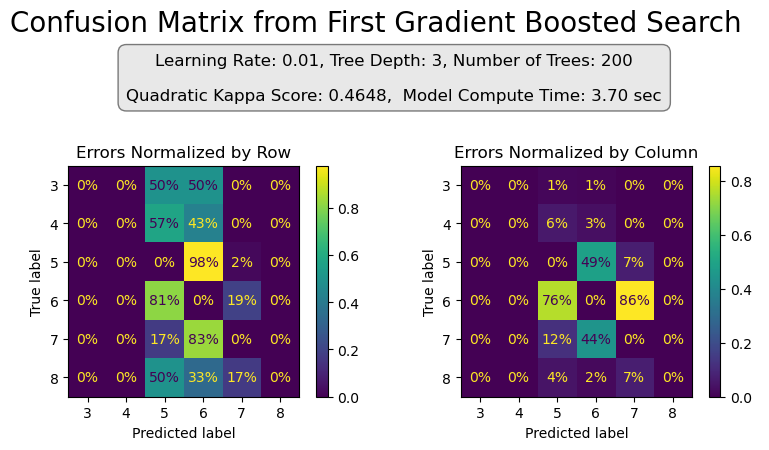

In [140]:
# Create the figure and gridspec
fig = plt.figure(figsize = (8,4.5))
grid_spec = GridSpec(3, 2, figure=fig, width_ratios = [1,1], height_ratios=[1,2,10])

# Model specs subplot
model_specs=  f"Learning Rate: {best_gb.learning_rate}, Tree Depth: {best_gb.max_depth}, Number of Trees: {best_gb.n_estimators}\n\nQuadratic Kappa Score: {kappa:.4f},  Model Compute Time: {retrain_time:.2f} sec"   
center_ax = fig.add_subplot(grid_spec[1, :])

# plt.center_ax_adjust(hspace = 0.5)
center_text = center_ax.text(0.5, 0.55, model_specs, ha='center', fontsize=12,
                           bbox=dict(facecolor='lightgray', alpha=0.5, boxstyle='round,pad=0.5'))
center_ax.axis('off')

sample_weight = (y_pred != y_val)
# Row (True) Normalized Confusion Matrix Subplot
normalized_conf_matrix_display = ConfusionMatrixDisplay.from_predictions(y_val, y_pred,
                                                                         sample_weight = sample_weight,
                                                                         normalize='true',
                                                                         values_format='.0%',
                                                                         ax=fig.add_subplot(grid_spec[2, 0]))
normalized_conf_matrix_display.ax_.set_title("Errors Normalized by Row")

# Column (Predicted) Normalized Confusion Matrix Subplot
normalized_conf_matrix_display = ConfusionMatrixDisplay.from_predictions(y_val, y_pred,
                                                                         sample_weight = sample_weight,
                                                                         normalize='pred',
                                                                         values_format='.0%',
                                                                         ax=fig.add_subplot(grid_spec[2, 1]))
normalized_conf_matrix_display.ax_.set_title("Errors Normalized by Column")

# Adjust Layout
plt.tight_layout()
fig.suptitle("Confusion Matrix from First Gradient Boosted Search", fontsize=20)

# Save and show the figure
output_filename = f"{gb_png_output_path}/gb_cm_err kappa={kappa:.4f}  est: {best_gb.n_estimators}   LR: {best_gb.learning_rate}   depth: {best_gb.max_depth}  run_time: {retrain_time:.2f}.png"
plt.savefig(output_filename)
plt.show()

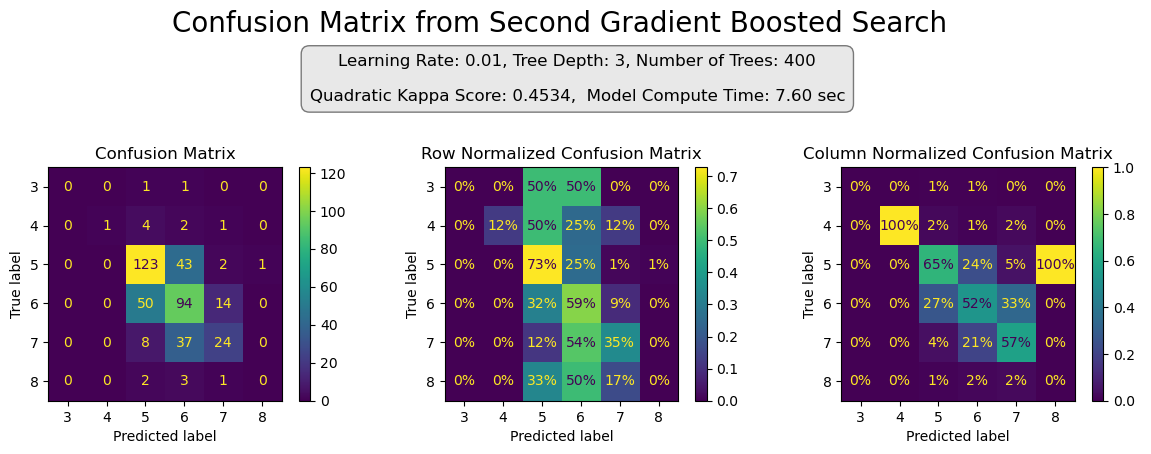

In [148]:
# Create the figure and gridspec
fig = plt.figure(figsize = (12,4.5))
grid_spec = GridSpec(3, 3, figure=fig, width_ratios = [1,1,1], height_ratios=[1,2,10])

# Model specs subplot
model_specs_2 =  f"Learning Rate: {best_gb_2.learning_rate}, Tree Depth: {best_gb_2.max_depth}, Number of Trees: {best_gb_2.n_estimators}\n\nQuadratic Kappa Score: {kappa_2:.4f},  Model Compute Time: {retrain_time_2:.2f} sec"   
center_ax = fig.add_subplot(grid_spec[1, :])

# plt.center_ax_adjust(hspace = 0.5)
center_text = center_ax.text(0.5, 0.55, model_specs_2, ha='center', fontsize=12,
                           bbox=dict(facecolor='lightgray', alpha=0.5, boxstyle='round,pad=0.5'))
center_ax.axis('off')

# Confusion Matrix Subplot
conf_matrix_display = ConfusionMatrixDisplay.from_predictions(y_val, y_pred_2, ax=fig.add_subplot(grid_spec[2, 0]))
conf_matrix_display.ax_.set_title("Confusion Matrix")

# Row (True) Normalized Confusion Matrix Subplot
row_normalized_conf_matrix_display = ConfusionMatrixDisplay.from_predictions(y_val, y_pred_2,
                                                                         normalize='true',
                                                                         values_format='.0%',
                                                                         ax=fig.add_subplot(grid_spec[2, 1]))
row_normalized_conf_matrix_display.ax_.set_title("Row Normalized Confusion Matrix")

# Column (Predicted) Normalized Confusion Matrix Subplot
clm_normalized_conf_matrix_display = ConfusionMatrixDisplay.from_predictions(y_val, y_pred_2,
                                                                         normalize='pred',
                                                                         values_format='.0%',
                                                                         ax=fig.add_subplot(grid_spec[2, 2]))
clm_normalized_conf_matrix_display.ax_.set_title("Column Normalized Confusion Matrix")

# Adjust Layout
plt.tight_layout()
fig.suptitle("Confusion Matrix from Second Gradient Boosted Search", fontsize=20)

# Save and show the figure
output_filename = f"{gb_png_output_path}/gb_cm kappa={kappa_2:.4f}  est: {best_gb_2.n_estimators}   LR: {best_gb_2.learning_rate}   depth: {best_gb_2.max_depth}  run_time: {retrain_time_2:.2f}.png"
plt.savefig(output_filename)
plt.show()

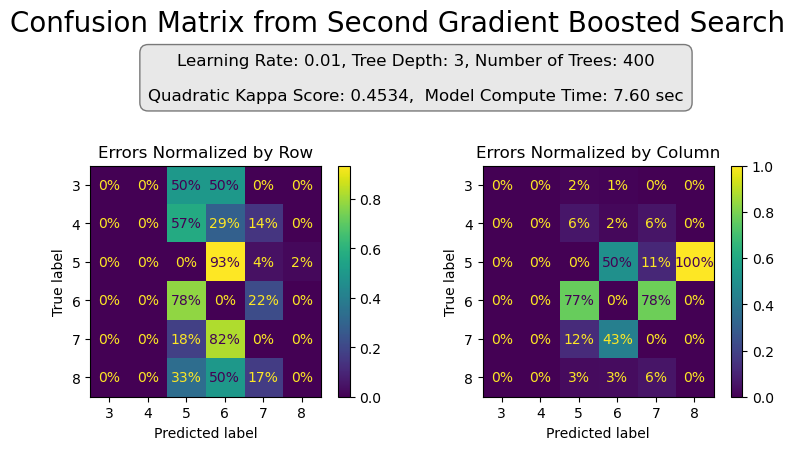

In [151]:
# Create the figure and gridspec
fig = plt.figure(figsize = (8,4.5))
grid_spec = GridSpec(3, 2, figure=fig, width_ratios = [1,1], height_ratios=[1,2,10])

# Model specs subplot
model_specs_2=  f"Learning Rate: {best_gb_2.learning_rate}, Tree Depth: {best_gb_2.max_depth}, Number of Trees: {best_gb_2.n_estimators}\n\nQuadratic Kappa Score: {kappa_2:.4f},  Model Compute Time: {retrain_time_2:.2f} sec"   
center_ax = fig.add_subplot(grid_spec[1, :])

# plt.center_ax_adjust(hspace = 0.5)
center_text = center_ax.text(0.5, 0.55, model_specs_2, ha='center', fontsize=12,
                           bbox=dict(facecolor='lightgray', alpha=0.5, boxstyle='round,pad=0.5'))
center_ax.axis('off')

sample_weight = (y_pred_2 != y_val)
# Row (True) Normalized Confusion Matrix Subplot
row_normalized_conf_matrix_display = ConfusionMatrixDisplay.from_predictions(y_val, y_pred_2,
                                                                         sample_weight = sample_weight,
                                                                         normalize='true',
                                                                         values_format='.0%',
                                                                         ax=fig.add_subplot(grid_spec[2, 0]))
row_normalized_conf_matrix_display.ax_.set_title("Errors Normalized by Row")

# Column (Predicted) Normalized Confusion Matrix Subplot
clm_normalized_conf_matrix_display = ConfusionMatrixDisplay.from_predictions(y_val, y_pred_2,
                                                                         sample_weight = sample_weight,
                                                                         normalize='pred',
                                                                         values_format='.0%',
                                                                         ax=fig.add_subplot(grid_spec[2, 1]))
clm_normalized_conf_matrix_display.ax_.set_title("Errors Normalized by Column")

# Adjust Layout
plt.tight_layout()
fig.suptitle("Confusion Matrix from Second Gradient Boosted Search", fontsize=20)

# Save and show the figure
output_filename = f"{gb_png_output_path}/gb_cm_err kappa={kappa_2:.4f}  est: {best_gb_2.n_estimators}   LR: {best_gb_2.learning_rate}   depth: {best_gb_2.max_depth}  run_time: {retrain_time_2:.2f}.png"
plt.savefig(output_filename)
plt.show()

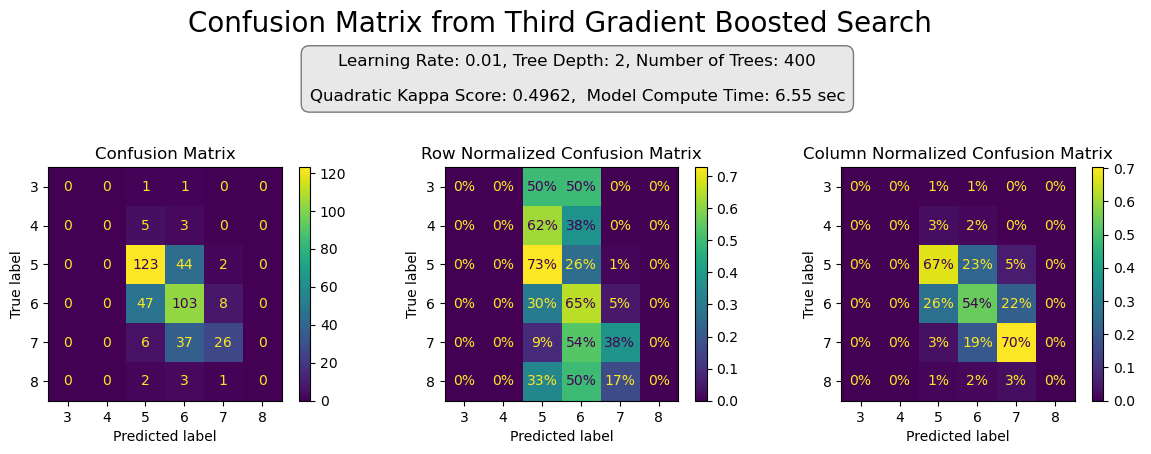

In [152]:
# Create the figure and gridspec
fig = plt.figure(figsize = (12,4.5))
grid_spec = GridSpec(3, 3, figure=fig, width_ratios = [1,1,1], height_ratios=[1,2,10])

# Model specs subplot
model_specs_3 =  f"Learning Rate: {best_gb_3.learning_rate}, Tree Depth: {best_gb_3.max_depth}, Number of Trees: {best_gb_3.n_estimators}\n\nQuadratic Kappa Score: {kappa_3:.4f},  Model Compute Time: {retrain_time_3:.2f} sec"   
center_ax = fig.add_subplot(grid_spec[1, :])

# plt.center_ax_adjust(hspace = 0.5)
center_text = center_ax.text(0.5, 0.55, model_specs_3, ha='center', fontsize=12,
                           bbox=dict(facecolor='lightgray', alpha=0.5, boxstyle='round,pad=0.5'))
center_ax.axis('off')

# Confusion Matrix Subplot
conf_matrix_display = ConfusionMatrixDisplay.from_predictions(y_val, y_pred_3, ax=fig.add_subplot(grid_spec[2, 0]))
conf_matrix_display.ax_.set_title("Confusion Matrix")

# Row (True) Normalized Confusion Matrix Subplot
row_normalized_conf_matrix_display = ConfusionMatrixDisplay.from_predictions(y_val, y_pred_3,
                                                                         normalize='true',
                                                                         values_format='.0%',
                                                                         ax=fig.add_subplot(grid_spec[2, 1]))
row_normalized_conf_matrix_display.ax_.set_title("Row Normalized Confusion Matrix")

# Column (Predicted) Normalized Confusion Matrix Subplot
clm_normalized_conf_matrix_display = ConfusionMatrixDisplay.from_predictions(y_val, y_pred_3,
                                                                         normalize='pred',
                                                                         values_format='.0%',
                                                                         ax=fig.add_subplot(grid_spec[2, 2]))
clm_normalized_conf_matrix_display.ax_.set_title("Column Normalized Confusion Matrix")

# Adjust Layout
plt.tight_layout()
fig.suptitle("Confusion Matrix from Third Gradient Boosted Search", fontsize=20)

# Save and show the figure
output_filename = f"{gb_png_output_path}/gb_cm kappa={kappa_3:.4f}  est: {best_gb_3.n_estimators}   LR: {best_gb_3.learning_rate}   depth: {best_gb_3.max_depth}  run_time: {retrain_time_3:.2f}.png"
plt.savefig(output_filename)
plt.show()

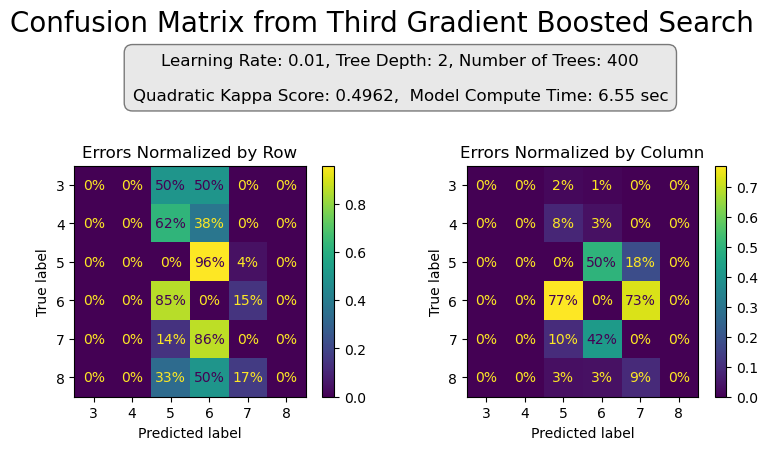

In [156]:
# Create the figure and gridspec
fig = plt.figure(figsize = (8,4.5))
grid_spec = GridSpec(3, 2, figure=fig, width_ratios = [1,1], height_ratios=[1,2,10])

# Model specs subplot
model_specs_3 =  f"Learning Rate: {best_gb_3.learning_rate}, Tree Depth: {best_gb_3.max_depth}, Number of Trees: {best_gb_3.n_estimators}\n\nQuadratic Kappa Score: {kappa_3:.4f},  Model Compute Time: {retrain_time_3:.2f} sec"   
center_ax = fig.add_subplot(grid_spec[1, :])

# plt.center_ax_adjust(hspace = 0.5)
center_text = center_ax.text(0.5, 0.55, model_specs_3, ha='center', fontsize=12,
                           bbox=dict(facecolor='lightgray', alpha=0.5, boxstyle='round,pad=0.5'))
center_ax.axis('off')

sample_weight = (y_pred_3 != y_val)
# Row (True) Normalized Confusion Matrix Subplot
row_normalized_conf_matrix_display = ConfusionMatrixDisplay.from_predictions(y_val, y_pred_3,
                                                                         sample_weight = sample_weight,
                                                                         normalize='true',
                                                                         values_format='.0%',
                                                                         ax=fig.add_subplot(grid_spec[2, 0]))
row_normalized_conf_matrix_display.ax_.set_title("Errors Normalized by Row")

# Column (Predicted) Normalized Confusion Matrix Subplot
clm_normalized_conf_matrix_display = ConfusionMatrixDisplay.from_predictions(y_val, y_pred_3,
                                                                         sample_weight = sample_weight,
                                                                         normalize='pred',
                                                                         values_format='.0%',
                                                                         ax=fig.add_subplot(grid_spec[2, 1]))
clm_normalized_conf_matrix_display.ax_.set_title("Errors Normalized by Column")

# Adjust Layout
plt.tight_layout()
fig.suptitle("Confusion Matrix from Third Gradient Boosted Search", fontsize=20)

# Save and show the figure
output_filename = f"{gb_png_output_path}/gb_cm_err kappa={kappa_3:.4f}  est: {best_gb_3.n_estimators}   LR: {best_gb_3.learning_rate}   depth: {best_gb_3.max_depth}  run_time: {retrain_time_3:.2f}.png"
plt.savefig(output_filename)
plt.show()

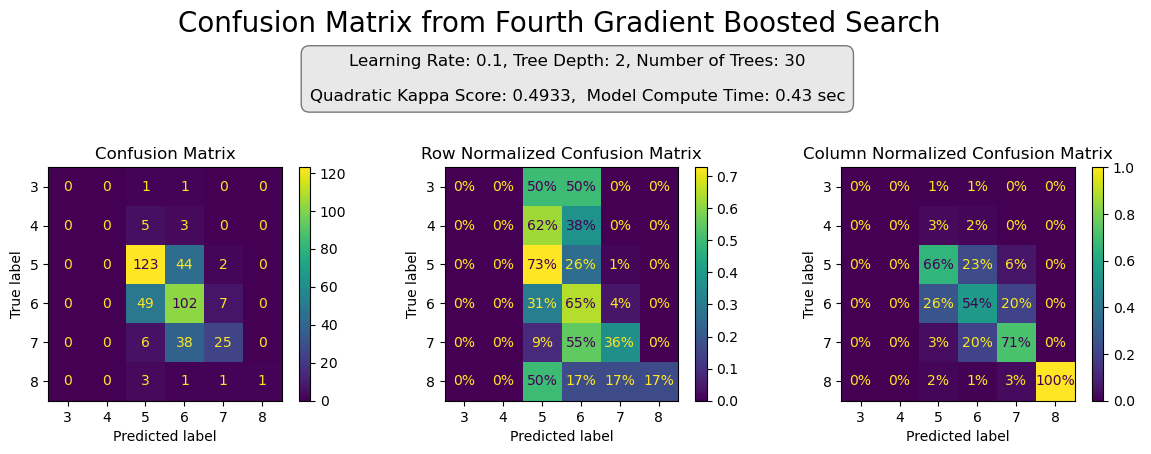

In [157]:
# Create the figure and gridspec
fig = plt.figure(figsize = (12,4.5))
grid_spec = GridSpec(3, 3, figure=fig, width_ratios = [1,1,1], height_ratios=[1,2,10])

# Model specs subplot
model_specs_4 =  f"Learning Rate: {best_gb_4.learning_rate}, Tree Depth: {best_gb_4.max_depth}, Number of Trees: {best_gb_4.n_estimators}\n\nQuadratic Kappa Score: {kappa_4:.4f},  Model Compute Time: {retrain_time_4:.2f} sec"   
center_ax = fig.add_subplot(grid_spec[1, :])

# plt.center_ax_adjust(hspace = 0.5)
center_text = center_ax.text(0.5, 0.55, model_specs_4, ha='center', fontsize=12,
                           bbox=dict(facecolor='lightgray', alpha=0.5, boxstyle='round,pad=0.5'))
center_ax.axis('off')

# Confusion Matrix Subplot
conf_matrix_display = ConfusionMatrixDisplay.from_predictions(y_val, y_pred_4, ax=fig.add_subplot(grid_spec[2, 0]))
conf_matrix_display.ax_.set_title("Confusion Matrix")

# Row (True) Normalized Confusion Matrix Subplot
row_normalized_conf_matrix_display = ConfusionMatrixDisplay.from_predictions(y_val, y_pred_4,
                                                                         normalize='true',
                                                                         values_format='.0%',
                                                                         ax=fig.add_subplot(grid_spec[2, 1]))
row_normalized_conf_matrix_display.ax_.set_title("Row Normalized Confusion Matrix")

# Column (Predicted) Normalized Confusion Matrix Subplot
clm_normalized_conf_matrix_display = ConfusionMatrixDisplay.from_predictions(y_val, y_pred_4,
                                                                         normalize='pred',
                                                                         values_format='.0%',
                                                                         ax=fig.add_subplot(grid_spec[2, 2]))
clm_normalized_conf_matrix_display.ax_.set_title("Column Normalized Confusion Matrix")

# Adjust Layout
plt.tight_layout()
fig.suptitle("Confusion Matrix from Fourth Gradient Boosted Search", fontsize=20)

# Save and show the figure
output_filename = f"{gb_png_output_path}/gb_cm kappa={kappa_4:.4f}  est: {best_gb_4.n_estimators}   LR: {best_gb_4.learning_rate}   depth: {best_gb_4.max_depth}  run_time: {retrain_time_4:.2f}.png"
plt.savefig(output_filename)
plt.show()

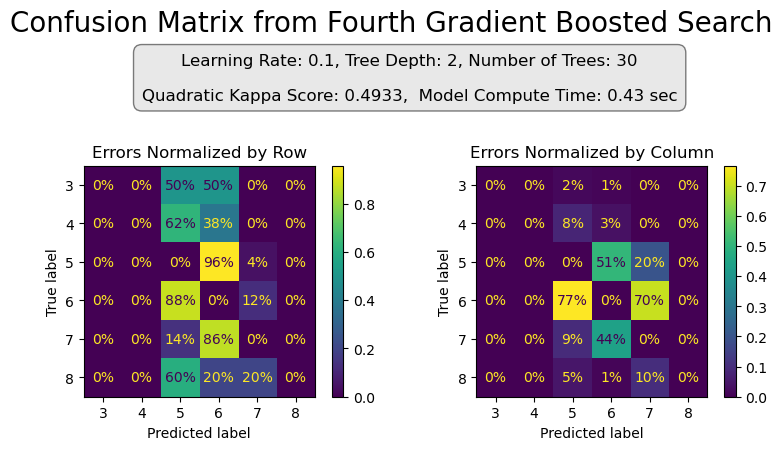

In [159]:
# Create the figure and gridspec
fig = plt.figure(figsize = (8,4.5))
grid_spec = GridSpec(3, 2, figure=fig, width_ratios = [1,1], height_ratios=[1,2,10])

# Model specs subplot
model_specs_4 =  f"Learning Rate: {best_gb_4.learning_rate}, Tree Depth: {best_gb_4.max_depth}, Number of Trees: {best_gb_4.n_estimators}\n\nQuadratic Kappa Score: {kappa_4:.4f},  Model Compute Time: {retrain_time_4:.2f} sec"   
center_ax = fig.add_subplot(grid_spec[1, :])

# plt.center_ax_adjust(hspace = 0.5)
center_text = center_ax.text(0.5, 0.55, model_specs_4, ha='center', fontsize=12,
                           bbox=dict(facecolor='lightgray', alpha=0.5, boxstyle='round,pad=0.5'))
center_ax.axis('off')

sample_weight = (y_pred_4 != y_val)
# Row (True) Normalized Confusion Matrix Subplot
row_normalized_conf_matrix_display = ConfusionMatrixDisplay.from_predictions(y_val, y_pred_4,
                                                                         sample_weight = sample_weight,
                                                                         normalize='true',
                                                                         values_format='.0%',
                                                                         ax=fig.add_subplot(grid_spec[2, 0]))
row_normalized_conf_matrix_display.ax_.set_title("Errors Normalized by Row")

# Column (Predicted) Normalized Confusion Matrix Subplot
clm_normalized_conf_matrix_display = ConfusionMatrixDisplay.from_predictions(y_val, y_pred_4,
                                                                         sample_weight = sample_weight,
                                                                         normalize='pred',
                                                                         values_format='.0%',
                                                                         ax=fig.add_subplot(grid_spec[2, 1]))
clm_normalized_conf_matrix_display.ax_.set_title("Errors Normalized by Column")

# Adjust Layout
plt.tight_layout()
fig.suptitle("Confusion Matrix from Fourth Gradient Boosted Search", fontsize=20)

# Save and show the figure
output_filename = f"{gb_png_output_path}/gb_cm_err kappa={kappa_4:.4f}  est: {best_gb_4.n_estimators}   LR: {best_gb_4.learning_rate}   depth: {best_gb_4.max_depth}  run_time: {retrain_time_4:.2f}.png"
plt.savefig(output_filename)
plt.show()

# Make Predictions on Kaggle Provided Test Dataset

In [ ]:
final_model_1 = 